<a href="https://colab.research.google.com/github/katia-kitaguti/pyspark-subscription-prediction/blob/main/202401_%7C_Bank_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About Pyspark

Pyspark is an interface of Apache Spark in Python. You can deal with a real-time, large-scale data, as well as manipulating and analysing data.

In order to learn more regarding it, I used as a reference the article published in Towards Data Science, which can be checked in "References" part.

I used a base download from Kaggle, which is related to direct campaigns (phone calls) of a Portuguese banking institution. The purpose is to predict whether the client will subscribe (Yes/No) under a term deposit.

# Import Libraries

In [1]:
# !pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=3948309c307ce923f1d28fdf682c175ecfdd73815fce0a1a4ac0697e76e2b234
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
# pip show pandas

In [2]:
# !pip install pandas.plotting

ERROR: Could not find a version that satisfies the requirement pandas.plotting (from versions: none)
ERROR: No matching distribution found for pandas.plotting


In [4]:
# Deal with dataframes
import pandas as pd
import numpy as np
# Accessing GCP Data
from google.colab import drive
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.service_account import ServiceAccountCredentials

##### Pyspark
# Change data format
from pyspark.sql.types import IntegerType,BooleanType,DateType
# Pyspark
from pyspark.sql import SparkSession
# Pyspark ML
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
# Pyspark Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Pyspark Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
#Pyspark Random Forest
from pyspark.ml.classification import RandomForestClassifier
# Pyspark Gradient_boosted Tree Classifier
from pyspark.ml.classification import GBTClassifier
#Create tables with pyspark
from pyspark import SparkContext, SQLContext
from pyspark.sql import Row
#Deal with functions
from pyspark.sql.functions import col, count, when
# Tuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#Feature Selection
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline


# Plot Scatter matrix
import plotly.express as px
# Others plot format
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


# Exploratory Data Analysis (EDA)

In [5]:
# I uploaded the csv clicking in the document button locatted in the left bar in google colab. After it uploaded, I got the copy its path
spark = SparkSession.builder.appName('ml-lg-bank').getOrCreate()
url = "/content/bank.csv"
df_bnk = spark.createDataFrame(pd.read_csv(url))

In [6]:
df_bnk.printSchema()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: long (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: long (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [7]:
# Checking whether there is null values in the columns or not
df_bnk_checkNulls = df_bnk.select([count(when(col(i).isNull(), i )).alias(i) for i in df_bnk.columns])
df_bnk_checkNulls.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+



In [8]:
#showing all the distincts values from each column
for column_value in df_bnk.columns:
  print(df_bnk.select(column_value).distinct().collect())

[Row(age=29), Row(age=26), Row(age=65), Row(age=54), Row(age=19), Row(age=22), Row(age=77), Row(age=34), Row(age=50), Row(age=57), Row(age=32), Row(age=43), Row(age=84), Row(age=31), Row(age=39), Row(age=25), Row(age=95), Row(age=71), Row(age=68), Row(age=72), Row(age=87), Row(age=58), Row(age=27), Row(age=63), Row(age=56), Row(age=51), Row(age=52), Row(age=79), Row(age=41), Row(age=28), Row(age=33), Row(age=85), Row(age=48), Row(age=67), Row(age=44), Row(age=61), Row(age=37), Row(age=83), Row(age=55), Row(age=74), Row(age=62), Row(age=49), Row(age=35), Row(age=80), Row(age=66), Row(age=76), Row(age=92), Row(age=36), Row(age=75), Row(age=78), Row(age=18), Row(age=69), Row(age=21), Row(age=59), Row(age=81), Row(age=38), Row(age=82), Row(age=42), Row(age=30), Row(age=73), Row(age=90), Row(age=23), Row(age=46), Row(age=70), Row(age=20), Row(age=86), Row(age=60), Row(age=93), Row(age=40), Row(age=64), Row(age=45), Row(age=53), Row(age=47), Row(age=24), Row(age=88), Row(age=89)]
[Row(job='m

In [9]:
#Accessing 10 first rows in our dataframe
pd.DataFrame(df_bnk.take(10), columns=df_bnk.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [10]:
# Converting the long type to integer
df_bnk = df_bnk.withColumn("age",df_bnk.age.cast('int'))
df_bnk = df_bnk.withColumn("balance",df_bnk.balance.cast('int'))
df_bnk = df_bnk.withColumn("day",df_bnk.day.cast('int'))
df_bnk = df_bnk.withColumn("duration",df_bnk.balance.cast('int'))
df_bnk = df_bnk.withColumn("campaign",df_bnk.campaign.cast('int'))
df_bnk = df_bnk.withColumn("pdays",df_bnk.pdays.cast('int'))
df_bnk = df_bnk.withColumn("previous",df_bnk.balance.cast('int'))

numeric_features = [t[0] for t in df_bnk.dtypes if t[1] == 'int']
df_bnk.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,1528.5385235620856,2.508421429851281,51.33040673714388,1528.5385235620856
2,stddev,11.913369192215526,3225.4133259461505,8.420739541006458,3225.4133259461505,2.7220771816614855,108.75828197197711,3225.4133259461505
3,min,18,-6847,1,-6847,1,-1,-6847
4,max,95,81204,31,81204,63,854,81204


In [11]:
numeric_data = df_bnk.select(numeric_features).toPandas()
fig = px.scatter_matrix(numeric_data)

# Update the layout
n = len(numeric_data.columns)
for i in range(n):
    fig.update_yaxes(title_text="", row=i+1, col=1)
    fig.update_xaxes(title_text="", row=n, col=i+1)

# Show the plot
fig.show()

In [12]:
# Extracting the columns of day and month
df_bnk = df_bnk.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df_bnk.columns
df_bnk.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



# Preparation for Machine Learning

In [13]:
categoricalCols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalCols:
  stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
  stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol='label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalCols] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [14]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_bnk)
df_bnk = pipelineModel.transform(df_bnk)
selectedCols = ['label', 'features'] + cols
df_bnk = df_bnk.select(selectedCols)
df_bnk.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [15]:
pd.DataFrame(df_bnk.take(10), columns=df_bnk.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
label,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54,42,56,60,37,28
job,admin.,admin.,technician,services,admin.,management,management,retired,technician,services
marital,married,married,married,married,married,single,married,divorced,married,single
education,secondary,secondary,secondary,secondary,tertiary,tertiary,tertiary,secondary,secondary,secondary
default,no,no,no,no,no,no,no,no,no,no
balance,2343,45,1270,2476,184,0,830,545,1,5090
housing,yes,no,yes,yes,no,yes,yes,yes,yes,yes
loan,no,no,no,no,no,yes,yes,no,no,no


In [16]:
train, test = df_bnk.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset count: " + str(train.count()))
print("Test Dataset count: " + str(test.count()))

Training Dataset count: 7853
Test Dataset count: 3309


# Logistic Regression Model

In [17]:
logistic_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
logistic_regModel = logistic_reg.fit(train)

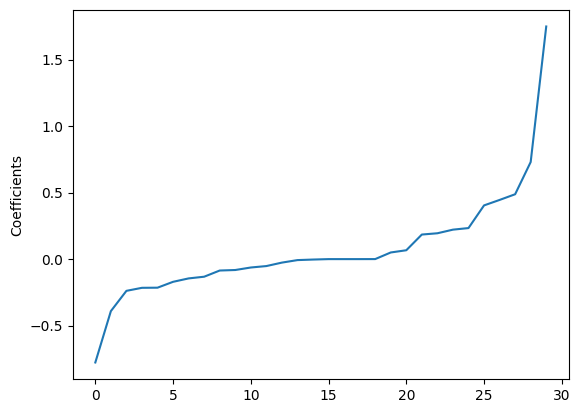

In [18]:
coeff = np.sort(logistic_regModel.coefficients)
plt.plot(coeff)
plt.ylabel('Coefficients')
plt.show()

In [19]:
trainingSummary = logistic_regModel.summary

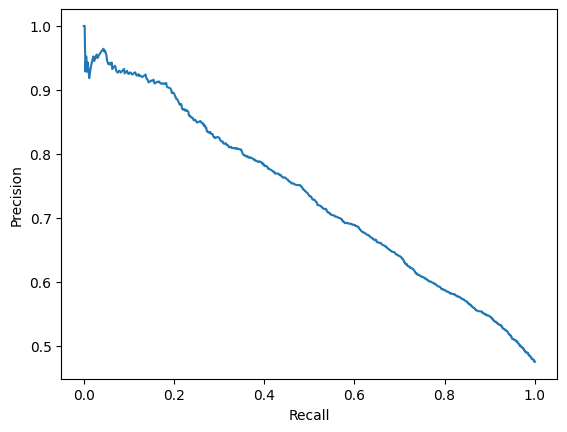

In [20]:
prec_rec = trainingSummary.pr.toPandas()
plt.plot(prec_rec['recall'], prec_rec['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [21]:
# Making predictions
predictions_lr = logistic_regModel.transform(test)
predictions_lr.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 27|management|  1.0|[-0.0414330358373...|       1.0|[0.48964322261852...|
| 45|management|  1.0|[0.24437022010240...|       0.0|[0.56079033862356...|
| 58|management|  1.0|[1.08726703530381...|       0.0|[0.74786673727448...|
| 59|management|  1.0|[0.07059050992595...|       0.0|[0.51764030292445...|
| 46|management|  1.0|[0.09116998635519...|       0.0|[0.52277672216147...|
| 37|management|  1.0|[-0.1327151592080...|       1.0|[0.46686982361093...|
| 48|management|  1.0|[-2.2330835821037...|       1.0|[0.09681866230349...|
| 47|management|  1.0|[0.95829285990973...|       0.0|[0.72277987707981...|
| 49|management|  1.0|[0.27732202959835...|       0.0|[0.56888956191128...|
| 40|management|  1.0|[0.44962165969452...|       0.0|[0.61054927638721...|
+---+-------

In [22]:
# Evaluating Logistic Regression Model
evaluator_lr = BinaryClassificationEvaluator()
print('Test Area under ROC', + evaluator_lr.evaluate(predictions_lr))

Test Area under ROC 0.7487691616446068


In [23]:
roc_lr = evaluator_lr.evaluate(predictions_lr)

# Decision Tree Model

In [24]:
decision_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
decision_treeModel = decision_tree.fit(train)
predictions_dt =  decision_treeModel.transform(test)
predictions_dt.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+-------------+----------+--------------------+
|age|       job|label|rawPrediction|prediction|         probability|
+---+----------+-----+-------------+----------+--------------------+
| 27|management|  1.0|    [0.0,5.0]|       1.0|           [0.0,1.0]|
| 45|management|  1.0|[610.0,301.0]|       0.0|[0.66959385290889...|
| 58|management|  1.0| [101.0,23.0]|       0.0|[0.81451612903225...|
| 59|management|  1.0|[285.0,517.0]|       1.0|[0.35536159600997...|
| 46|management|  1.0|  [22.0,36.0]|       1.0|[0.37931034482758...|
| 37|management|  1.0|  [26.0,66.0]|       1.0|[0.28260869565217...|
| 48|management|  1.0| [43.0,591.0]|       1.0|[0.06782334384858...|
| 47|management|  1.0|[493.0,134.0]|       0.0|[0.78628389154704...|
| 49|management|  1.0|  [22.0,36.0]|       1.0|[0.37931034482758...|
| 40|management|  1.0|  [26.0,66.0]|       1.0|[0.28260869565217...|
+---+----------+-----+-------------+----------+--------------------+
only showing top 10 rows



In [25]:
# evaluating decision tree classifier
evaluator_dt = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.616361409470254


In [26]:
roc_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "areaUnderROC"})

Through the results above, it seems that Logistic Regression performed better than Decision Tree.

Let`s try another to improve the Decision Tree using Ensemble methods, such as Random Forest and Gradient-Boosted Tree.

# Random Forest Classifier

In [27]:
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
random_forestModel = random_forest.fit(train)
predictions_rf = random_forestModel.transform(test)
predictions_rf.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 27|management|  1.0|[8.70778380599938...|       1.0|[0.43538919029996...|
| 45|management|  1.0|[9.37169874917981...|       1.0|[0.46858493745899...|
| 58|management|  1.0|[12.6196581991157...|       0.0|[0.63098290995578...|
| 59|management|  1.0|[9.12997879451542...|       1.0|[0.45649893972577...|
| 46|management|  1.0|[12.3992692488808...|       0.0|[0.61996346244404...|
| 37|management|  1.0|[8.07296008105638...|       1.0|[0.40364800405281...|
| 48|management|  1.0|[2.76072369590504...|       1.0|[0.13803618479525...|
| 47|management|  1.0|[14.1192741907729...|       0.0|[0.70596370953864...|
| 49|management|  1.0|[11.1311570216433...|       0.0|[0.55655785108216...|
| 40|management|  1.0|[11.0804172388058...|       0.0|[0.55402086194029...|
+---+-------

In [28]:
evaluator_rf = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_rf.evaluate(predictions_rf, {evaluator_rf.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7438296829029091


In [29]:
roc_rf = evaluator_rf.evaluate(predictions_rf, {evaluator_rf.metricName: "areaUnderROC"})

# Gradient-Boosted Tree Classifier

In [30]:
gradient_boosted = GBTClassifier(maxIter=10)
gradient_boostedModel = gradient_boosted.fit(train)
predictions_gbt = gradient_boostedModel.transform(test)
predictions_gbt.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 27|management|  1.0|[-0.6440585949437...|       1.0|[0.21617166646003...|
| 45|management|  1.0|[0.20455123259167...|       0.0|[0.60087264732293...|
| 58|management|  1.0|[0.75388159386516...|       0.0|[0.81872947477740...|
| 59|management|  1.0|[0.14070012981743...|       0.0|[0.56988948276042...|
| 46|management|  1.0|[0.16980903687363...|       0.0|[0.58409774550027...|
| 37|management|  1.0|[-0.1583089981094...|       1.0|[0.42150018848000...|
| 48|management|  1.0|[-1.1801491627082...|       1.0|[0.08625068012001...|
| 47|management|  1.0|[0.45491097423630...|       0.0|[0.71296372652077...|
| 49|management|  1.0|[0.03188710643881...|       0.0|[0.51593815168077...|
| 40|management|  1.0|[0.23962388444058...|       0.0|[0.61757023061833...|
+---+-------

In [31]:
evaluator_gbt = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_gbt.evaluate(predictions_gbt, {evaluator_gbt.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7538299467717838


In [32]:
roc_gbt = evaluator_gbt.evaluate(predictions_gbt, {evaluator_gbt.metricName: "areaUnderROC"})

In [33]:
print("Logistic Regression: " + str(roc_lr))
print("Decision Tree: " + str(roc_dt))
print("Random Forest: " + str(roc_rf))
print("Gradient-Boosted Tree: " + str(roc_gbt))


Logistic Regression: 0.7487750253973796
Decision Tree: 0.616361409470254
Random Forest: 0.7438296829029093
Gradient-Boosted Tree: 0.7538299467717838


Looking the results displayed above, we can see that Gradient-Boosted performed better than the other 3.

Let`s try to apply hyperparameters on it.


# Applying Tuning Methods on Gradient-Boosted Model

In [34]:
print(gradient_boosted.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [35]:
paramGrid = (ParamGridBuilder()
            .addGrid(gradient_boosted.maxDepth, [3,6,9])
            .addGrid(gradient_boosted.maxBins, [20,60])
            .addGrid(gradient_boosted.maxIter, [10,20])
            .addGrid(gradient_boosted.stepSize, [0.05, 0.1])
            .build())

cross_val = CrossValidator(estimator=gradient_boosted, estimatorParamMaps=paramGrid, evaluator=evaluator_gbt, numFolds=5)

cross_valModel = cross_val.fit(train)
predictions_tun = cross_valModel.transform(test)
evaluation_result = evaluator_gbt.evaluate(predictions_tun)
evaluation_result

0.7613318854750455

In [36]:
print("Gradient-Boosted Tree: " + str(roc_gbt))
print("Tuned Gradient-Boosted Tree: " + str(evaluation_result))

Gradient-Boosted Tree: 0.7538299467717838
Tuned Gradient-Boosted Tree: 0.7613318854750455


# Feature Selection through Chi-Squared Selector

In [37]:
selector = ChiSqSelector(featuresCol='features', outputCol='selectedFeatures', labelCol='label', fpr=0.05)

pipeline = Pipeline(stages=[selector, gradient_boosted])

pipeline_model = pipeline.fit(train)

selected_features_train = pipeline_model.transform(train)

selected_features_test = pipeline_model.transform(test)

selected_features = selected_features_train.select('selectedFeatures').collect()[0]['selectedFeatures']

print("Selected Features:", selected_features)


Selected Features: (30,[0,11,13,16,17,18,19,21,24,25,26,27,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,850.0,850.0,2.0,-1.0,850.0])


In [38]:
# Evaluate the model on the test data
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
area_under_roc = evaluator.evaluate(selected_features_test)
print("Area under ROC:", area_under_roc)


Area under ROC: 0.7538299467717843


We noticed that the feature selection didn`t bring increment to our gradient boosted model.

# Trying to select the columns

In [39]:
# Access the coefficients
coefficients = logistic_regModel.coefficients

# Access the feature column names
feature_columns = train.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + \
                  train.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]

# Convert dictionaries to tuples before creating the mapping
feature_columns_tuples = [(d['name'], d['idx']) for d in feature_columns]

# Create a mapping of coefficients to feature column names
coefficients_mapping = dict(zip(feature_columns_tuples, coefficients))

# Print the coefficients mapped to feature column names
for feature, coefficient in coefficients_mapping.items():
    print(f"{feature}: {coefficient}")

('jobclassVec_management', 0): -0.13224789793183206
('jobclassVec_blue-collar', 1): -0.007403746040579797
('jobclassVec_technician', 2): -0.0818948082235892
('jobclassVec_admin.', 3): 0.06662684990145178
('jobclassVec_services', 4): -0.05224723498957836
('jobclassVec_retired', 5): 0.729814167969826
('jobclassVec_self-employed', 6): -0.0630204350797046
('jobclassVec_student', 7): 0.4448059512871793
('jobclassVec_unemployed', 8): 0.194257194982733
('jobclassVec_entrepreneur', 9): -0.17065258065946745
('jobclassVec_housemaid', 10): -0.21568025628709325
('maritalclassVec_married', 11): -0.2147846701268001
('maritalclassVec_single', 12): 0.04993805534786234
('educationclassVec_secondary', 13): -0.02622002453111428
('educationclassVec_tertiary', 14): 0.2214476610388966
('educationclassVec_primary', 15): -0.14500910114627663
('defaultclassVec_no', 16): 0.23335290454474888
('housingclassVec_no', 17): 0.48757653732432715
('loanclassVec_no', 18): 0.4037075950308285
('contactclassVec_cellular', 1

In [40]:
# Get the absolute values of coefficients and their corresponding feature names
coefficients_with_names = list(zip(coefficients, feature_columns))

# Sort by absolute coefficient values in descending order
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[0]), reverse=True)

# Select the top 20 features

top_feature_names = [feature_name for _, feature_name in sorted_coefficients[:10]]
top_feature_names = [feature_info['name'] for feature_info in top_feature_names]

In [41]:
top_feature_names

['poutcomeclassVec_success',
 'contactclassVec_unknown',
 'jobclassVec_retired',
 'housingclassVec_no',
 'jobclassVec_student',
 'loanclassVec_no',
 'poutcomeclassVec_unknown',
 'poutcomeclassVec_failure',
 'defaultclassVec_no',
 'educationclassVec_tertiary']

Through the above cell code, we can see that the top 10 features are related to the fields: poutcome, contact, job, housing, loan, default, education

In [113]:
# creating a copy of the dataframe filtering it according to these columns above
df_bnk_copy = df_bnk.alias('df_bnk_copy')
id(df_bnk_copy) == id(df_bnk)
df_bnk_copy = df_bnk_copy.select("poutcome", "contact", "job", "housing", "loan", "default", "education", "deposit", "age", "balance")
df_bnk_copy.printSchema()

root
 |-- poutcome: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- job: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- default: string (nullable = true)
 |-- education: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)



In [114]:
categoricalCols_copy = ['job', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages_copy = []

for categoricalCol_copy in categoricalCols_copy:
  stringIndexer_copy = StringIndexer(inputCol = categoricalCol_copy, outputCol = categoricalCol_copy + 'Index')
  encoder_copy = OneHotEncoder(inputCols=[stringIndexer_copy.getOutputCol()], outputCols=[categoricalCol_copy + "classVec"])
  stages_copy += [stringIndexer_copy, encoder_copy]

label_stringIdx_copy = StringIndexer(inputCol = 'deposit', outputCol='label')
stages_copy += [label_stringIdx_copy]

numericCols_copy = ['age', 'balance']
assemblerInputs_copy = [c + "classVec" for c in categoricalCols_copy] + numericCols_copy
assembler_copy = VectorAssembler(inputCols=assemblerInputs_copy, outputCol="features")
stages_copy += [assembler_copy]

In [115]:
pipeline_copy = Pipeline(stages = stages_copy)
pipelineModel_copy = pipeline_copy.fit(df_bnk_copy)
df_bnk_copy = pipelineModel_copy.transform(df_bnk_copy)
selectedCols_copy = ['label', 'features'] + [col for col in cols if col not in ['marital', 'duration', 'campaign', 'pdays', 'previous']]
df_bnk_copy = df_bnk_copy.select(selectedCols_copy)
df_bnk_copy.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [116]:
train_selFeature, test_selFeature = df_bnk_copy.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset count: " + str(train_selFeature.count()))
print("Test Dataset count: " + str(test_selFeature.count()))

Training Dataset count: 7853
Test Dataset count: 3309


In [117]:
gradient_boosted_sf = GBTClassifier(maxIter=10)
gradient_boostedModel_sf = gradient_boosted.fit(train_selFeature)
predictions_gbt_sf = gradient_boostedModel_sf.transform(test_selFeature)
predictions_gbt_sf.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 31|management|  1.0|[0.36975636539366...|       0.0|[0.67688929468950...|
| 28|management|  1.0|[-0.3744893151577...|       1.0|[0.32104389288233...|
| 32|management|  1.0|[-0.1802394711134...|       1.0|[0.41084363248007...|
| 33|management|  1.0|[-0.1656906959510...|       1.0|[0.41790454723944...|
| 39|management|  1.0|[-0.2005763418652...|       1.0|[0.40103542676595...|
| 45|management|  1.0|[-0.1656906959510...|       1.0|[0.41790454723944...|
| 58|management|  1.0|[-0.1987570298596...|       1.0|[0.40190976001164...|
| 52|management|  1.0|[-0.4060921526281...|       1.0|[0.30742522891150...|
| 28|management|  1.0|[-1.1629574761377...|       1.0|[0.08899931693224...|
| 37|management|  1.0|[-1.0915695468259...|       1.0|[0.10127485523500...|
+---+-------

In [118]:
evaluator_gbt_sf = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_gbt_sf.evaluate(predictions_gbt_sf, {evaluator_gbt_sf.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7435694788736308


In [119]:
roc_gbt_sf = evaluator_gbt.evaluate(predictions_gbt_sf, {evaluator_gbt_sf.metricName: "areaUnderROC"})

In [120]:
print("Gradient-Boosted Tree: " + str(roc_gbt))
print("Tuned Gradient-Boosted Tree: " + str(evaluation_result))
print("Selecting Features and Applying in the Gradient-Boosted Tree: " + str(roc_gbt_sf))

Gradient-Boosted Tree: 0.7538299467717838
Tuned Gradient-Boosted Tree: 0.7613318854750455
Selecting Features and Applying in the Gradient-Boosted Tree: 0.7435694788736309


# Summary


The best performed model was Tuned Gradient-Boosted Tree.

After applying feature selection, the model didn't have a good roc score, since the prior features were performed better, which could mean they described better the processes than reducing the features.

# References

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

https://spark.apache.org/docs/2.2.0/ml-features.html

https://www.youtube.com/watch?v=9X73jbQSglY